<a data-flickr-embed="true" href="https://www.flickr.com/photos/usfwsmtnprairie/30026674155/" title="Sunset on Seedskadee National Wildlife Refuge"><img src="https://live.staticflickr.com/5315/30026674155_d4d890b0ad_6k.jpg" width="6144" height="1913" alt="Sunset on Seedskadee National Wildlife Refuge"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>
<center>Figure: Sunset on Seedskadee National Wildlife Refuge, WY</center>
<center>Image Source: <a href="https://www.flickr.com/photos/usfwsmtnprairie/30026674155/" target="_blank">USFWS Mountain-Prairie, Tom Koerner</a> </center>
Author:<br>
Kelsey Beckrich<br>
Collaborators:<br>
Sarah Jaffe <br>
Nature Serve<br>

# Sage Advice: Can Remote Sensing Inform Sagebrush Conservation?
## Outline of Project Trajectory
This project started with two official goals:
* Use LIDAR data to reconstruct sagebrush ecosystem vegetation structure (height/coverage of shrubs vs. grasses)
* Use spectral data to reconstruct sagebrush ecosystem vegetation composition (taxonomic diversity/distribution)
    * Compare fine and medium spectral/spatial resolution data if possible.<br>
    
This project ended with reproducible workflows performing unsupervised endmember extraction and abundance maps for LANDSAT8  and the National Ecological Observatory Network's (NEON) Hyperspectral data, thereby resolving the second goal, but there were many lessons learned in the process. Consequently, this project became an unofficial review of the freely available LIDAR and spectral data over sagebrush ecosystems and was divided into three parts:

1. A workflow validating NEON Canopy Height Models (CHM) to *insitu* data, developed by Sarah Jaffe and Kelsey Beckrich and available for review  <a href= "https://github.com/kessb/sagebrush-ecosystem-modeling/tree/master/scripts" target="blank" > here</a>
2. A LANDSAT8 workflow for endmember extraction and abundance maps, developed by Sarah Jaffe and hosted on her <a href ="https://github.com/sarahmjaffe/sagebrush-ecosystem-modeling-with-landsat8" target="blank" > Sagebrush Ecosystem Modeling with Landsat 8 </a> github repository for review.
3. A NEON Hyperspectral data workflow, developed by Kelsey Beckrich and fully discussed below.

Besides the spectral library data, data in this workflow were collected near the Onaqui Mountains of Utah, a known sagebrush environment, in May of 2019.


## Background on Sagebrush Ecosystems

Easily overlooked, sagebrush ecosystems cover millions of acres across the Western United States and support over 350 species of other plants and animals. Some of these, like the arguably endangered Greater Sage Grouse, are found no where else. Even though sagebrush still has an extensive range, it has been massively fragmented by commercial land use and invasive cheatgrass; it is estimated that only 10% of remaining sagebrush ecosystems are representative of historic ecological conditions. Furthermore, warming temperatures from climate change are expected to shift the range of sagebrush north.  This brings us to the crux of the issue - even in reduced numbers, sagebrush still covers a highly dispersed area in the western United States, and developing effective conservation practices requires monitoring more land than is feasible through traditional means. Consequently, creating reproducible workflows that can both identify and visualize sagebrush ecosystem would be a tremendous resource to conservationists.


# Library Imports

In [1]:
# Import libraries for workflow
import warnings
import os
from glob import glob
import h5py
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.stats.stats import pearsonr
import pysptools.eea as eea  # endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pandas as pd
import earthpy as et
from earthpy.spatial import bytescale
# Helper functions from NEON's Hyperspectral Tutorial
from neon_helper_functions import *

%matplotlib inline

# Turn off warnings
warnings.filterwarnings('ignore')

# Check directory exists and set working directory
working_dir = os.path.join(et.io.HOME, 'earth-analytics')
if os.path.exists(working_dir) == False:
    os.mkdir(working_dir)
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# A Review of Hyperspectral Data Products
## AVIRIS and NEON: Data Coverage and Resolutions

Hyperspectral data from both AVIRIS and NEON were tested for this analysis. There are of course pros and cons to each data product. AVIRIS has better temporal coverage (2006-2019), but spatial coverage is generally focused to California, Nevada, and the Gulf of Mexico. NEON has excellent spatial coverage with data available for all of their 81 sites in the United States, but temporal coverage is poor (2017-2019, typically on a biannual basis). Both products are similar spectral resolutions - covering wavelengths from roughly 250-2500, but the NEON data is slightly finer spectral resolution as those wavelengths are divided into 426 bands as opposed to AVIRIS 224. NEON is also finer spatial resolution at 1 meter squared while AVIRIS is 20 meters squared. 

The main differentiator between the two data products was the level of documentation. AVIRIS data is geared towards processing in ENVI, and though there are free Python tools, such as MIT open source <a href="http://www.spectralpython.net/" target="blank" > Python Spectral (SPy)</a> module, documentation for working with AVIRIS in Python is relatively sparse. NEON on the other hand, offers a variety of tutorials on importing, processing, cleaning, subsetting, etc. their hyperspectral data. Consequently, the workflow and analysis were completed with NEON data. 

## NEON: Data Products Available

NEON's hyperspectral data is available in hierarchical data format (.h5) files of both variable length flightlines and mosaicked 1 kilometer squared tiles of those flightlines. These are roughly 1.4GB and 0.6GB per file, respectively. Since these files are large, they are time intensive to download and analyze, and the RAM required to work with the flightlines exceeded what my computer could handle without significantly subsetting by bands or cropping the extent. Consequently, this workflow uses only the 0.6GB tiled data which is available from NEON's <a href ="https://data.neonscience.org/data-products/DP3.30006.001" target= "blank" > Data Portal</a>.

Additional workflows are in progress to process the larger flightlines. Analysis of the flightlines is preferred since they can be more efficiently overlapped with *insitu* plots. This is because they cover a larger area and come with ancillary data files, such as RGB rasters and kmls of their flight paths. This allows for quick overlap between the much smaller ancillary files (125MB instead of 1.4GB) and plot polygons to determine which flightlines cover *insitu* sites. However, as mentioned previously, the raw flightline hyperspectral data are computationally intensive, therefore multiple approaches must be incorporated to subset and clean the flightlines for analysis.  <br>


## Hyperspectral Data Download
The following cells download the NEON tile(s) from figshare and open the file(s) into a dictionary with the tile coordinates as the dictionary key. Per NEON file naming conventions, pulling the tile coordinates from the file path is the easiest way to distinguish the files. This import process ensures the workflow is scalable. The specific tiles used in this workflow are publicly hosted on my <a href ="https://figshare.com/articles/dataset/NEON_Hyperspectral_Tiles/12584957" target ="blank" >figshare</a> and downloaded programmatically to ensure workflow reproducibility.


After randomly selecting and plotting multiple tiles from NEON's <a href="https://www.neonscience.org/field-sites/field-sites-map/ONAQ" target="_blank">ONAQ</a> site in Utah, I found several were edges of the flightlines. I discarded these tiles and kept the two whole tiles for the Endmember Sensistivity Analysis (ESA). After reviewing the unsupervised endmember extraction from the ESA, I chose to complete this workflow with tile 378000_4452000. I have left the figshare download for 374000_4449000 in the downloads cell below for future analysis, but it is commented out to reduce processing time since it is not essential for this workflow.

In [2]:
# Imports tile 374000_4449000
# et.data.get_data(url='https://ndownloader.figshare.com/files/23535881')
# Imports tile 378000_4452000
et.data.get_data(url='https://ndownloader.figshare.com/files/23535953')

'C:\\Users\\17205\\earth-analytics\\data\\earthpy-downloads\\NEON_D15_ONAQ_DP3_378000_4452000_reflectance.h5'

In [7]:
# Import hyp data into dict with tile number as key

ONAQ_hyp_refl = glob(os.path.join('data', 'earthpy-downloads', '*DP3*'))

# File import is scalable if multiple tiles are available
ONAQ_data = {}
for file in ONAQ_hyp_refl:
    data, metadata = read_neon_reflh5(file)
    data_clean, metadata_clean = clean_neon_refl_data(
        data, metadata)
    print('Tile Key:', os.path.basename(file)[18:32])
    ONAQ_data[os.path.basename(file)[18:32]] = {
        'reflectance': data_clean,
        'metadata': metadata_clean}
print('Raw Data Dimensions:', data.shape)
print('Cleaned Data Dimensions:', data_clean.shape)

Tile Key: 374000_4449000
Tile Key: 378000_4452000
Raw Data Dimensions: (1000, 1000, 426)
Cleaned Data Dimensions: (1000, 1000, 360)


# A Review of Data Validation Options

I explored multiple options for data validation, but there were significant limitations to each.

## Validation Against *Insitu* Data

The first option was to validate against NEON's *insitu* data from their <a href ="https://data.neonscience.org/data-products/DP1.10098.001#availability" target="blank"> Woody Plant Vegetation Structure </a> data product. According to the data product abstract:

"The exact measurements collected per individual depend on growth form, and these measurements are focused on enabling... *validation of multiple NEON airborne remote-sensing data products*. In general, *comparatively large individuals that are visible to remote-sensing instruments are mapped* and *other smaller individuals are tagged and measured but not mapped*" [emphasis mine].

The Woody Plant Vegetation Structure data for this site, collected September 2019, just four months after the hyperspectral data, included multiple identifications of Greater Sagebrush, *Artemsia tridentata*. Consequently, I built a workflow which imported the tabular species data, buffered the plot points of the plot centroids, clipped the flightlines to the plot extents, and plotted the spectral signature from several pixels in this plot area. 

Unfortunately, I realized pixels could not be mapped to documented plants. The only geospatial data available is related to the Plot ID's, not the Individual ID's of the plants. While the data product abstract provides no height threshold, presumably sagebrush are too small to be visible to remote sensing instruments and consequently not mapped on site. The best case scenario using this approach is stumbling upon pixels with the spectral signatures of sage by extracting spectra from plots with abundant sagebrush. However, this would introduce a significant degree of uncertainty since we cannot map the pixels to the known sage themselves. 


## Validation Against Isolated Spectral Signatures

This led to plan B. The USGS Spectral Library contained records for both greater sagebrush and the invasive cheatgrass. We found records for LANDSAT and Convolved to Terrestrial Spectrometers of AVIRIS 2014 which, with some manipulation, could be used as validation for NEON's hyperspectral data. 

There are of course significant sources of data uncertainty using this approach as well. The cheatgrass was collected from Arches National Park in Utah from a dry stem and leaves while the sagebrush sample was collected from cut leaves in Iron Hill, Colorado. Using samples from locations outside of the remote sensing area may introduce error from unique environmental conditions or localized genetic variation. There is also an issue of scale between the spectral library samples of individuals with cut leaves as opposed to remote sensing imagery of whole plants, or even whole populations of plants.

## Spectral Library Data Download
Spectral signatures for our focal species, greater sagebrush and cheatgrass, were downloaded from the USGS's <a href = "https://crustal.usgs.gov/speclab/" target= "blank" > Spectral Library </a> and are hosted on <a href ="https://figshare.com/authors/Sarah_Jaffe/8848913" target ="blank" > Sarah Jaffe's figshare </a> for reproducibilty. Again, the data import is designed to be scalable in case other spectral library data are added. The wavelengths from the spectral libraries were in microns and binned into larger groups (224 bands as opposed to the 360 cleaned bands from NEON). Therefore, the wavelengths needed to be converted to nanometers and interpolated to the same length as the NEON data. The following cells accomplish all data processing.

In [2]:
# Download data hosted on figshare
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262782')
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262785')

'C:\\Users\\17205\\earth-analytics\\data\\earthpy-downloads\\s07_AV14_Cheatgrass_ANP92-11A_BECKa_AREF'

In [3]:
# Create list of directories to spectral signatures
AV_spect_lib_dir = glob(os.path.join('data', 'earthpy-downloads', '*AV14*'))
AV_spect_sig = {}
# Remove unnecessary files, import reflectance and wavelength as arrays
for dirs in AV_spect_lib_dir:
    error_bar = sorted(glob(os.path.join(dirs, '*errorbar*')))
    resolution_file = sorted(glob(os.path.join(dirs, '*Resolution*')))
    if not len(error_bar) == 0:
        os.remove(error_bar[0])
    if not len(resolution_file) == 0:
        os.remove(resolution_file[0])
    txt_files = sorted(glob(os.path.join(dirs, '*txt*')))
    # Use vegetation type name from file path as dict key
    object_name = os.path.basename(txt_files[0]).split('_')[2]
    AV_spect_sig[object_name] = {
        'Resolution': np.loadtxt(txt_files[0], skiprows=1),
        'Wavelength': np.loadtxt(txt_files[1], skiprows=1)}
# Print available signatures for users
for key in AV_spect_sig.keys():
    print('Spectral signatures available for', key)

Spectral signatures available for Cheatgrass
Spectral signatures available for Sagebrush


In [4]:
# Clean spectral library bad reflectance values
cheatgrass_res, cheatgrass_wave = clean_spectral_array(
    object_spect_dict=AV_spect_sig['Cheatgrass'])
sagebrush_res, sagebrush_wave = clean_spectral_array(
    object_spect_dict=AV_spect_sig['Sagebrush'])

In [8]:
# Interpolate spectral library data to match hyperspectral dimension
interp_res_sagebrush = np.interp(np.array(
    ONAQ_data['378000_4452000']['metadata']['wavelength']),
    sagebrush_wave,
    sagebrush_res)
interp_res_cheatgrass = np.interp(
    np.array(ONAQ_data['378000_4452000']['metadata']['wavelength']),
    cheatgrass_wave,
    cheatgrass_res)

# Plot Pure Spectral Signatures for Focal Speccies
The following cell plots both spectral signatures and calculates the Pearson's Correlation Coefficient. The signatures need to be visualized and tested before any attempts to validate with the remote sensing data to ensure that sagebrush and cheatgrass have discernible spectral curves.


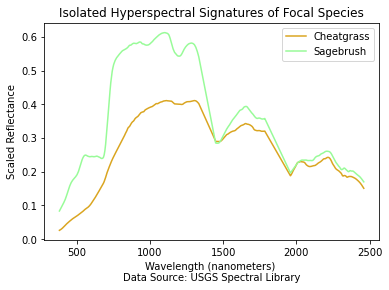

**************************************************
These spectral signatures are 86 percent similar.


In [8]:
# Plot spectral signatures from library
plot_path = os.path.join(
    'data', 'outputs', 'sagebrush_cheatgrass_sl_signatures.png')
fig, (ax) = plt.subplots()
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_cheatgrass, label='Cheatgrass',
        color='goldenrod')
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_sagebrush, label='Sagebrush',
        color='palegreen')
ax.set_xlabel('Wavelength (nanometers) \n'
              'Data Source: USGS Spectral Library',
              fontsize=10)
ax.set_title('Isolated Hyperspectral Signatures of Focal Species')

ax.set_ylabel('Scaled Reflectance')
plt.legend()
plt.savefig(plot_path,
            transparent=True)
plt.show()
print('**************************************************')
print('These spectral signatures are',
      int(pearsonr(interp_res_cheatgrass, interp_res_sagebrush)[0]*100),
      'percent similar.')

This plot shows that the spectral curves for the focal species are distinct. This is also supported by the Pearson's Correlation Coefficient of 86%. While a high degree of similarity is expected for two plant species, this correlation suggests that we will be able to discern between species in an endmember extraction and correlate endmembers to either the sagebrush shrub or the invasive grass without confusing the two.

# Create Objects for Endmember Extraction and Abundance Maps

We chose to use endmember extraction to identify landcover types in these images based on the readily available documentation for this type of analysis on large datasets, like hyperspectral data.

Endmember extraction algorithms allow each pixel to be unmixed into it's component landcover types, and the pure landcover spectra - or endmembers - are then grouped into the most prominent spectra in the image. The number of groupings of course depends on the level of detail requested/provided. This brings us to the first decision with endemember extraction - whether we would provide the endmembers we wanted the image grouped into, thereby creating a supervised endmember extraction or whether we would use PySpTool's NFINDR algorithm to extract the endmembers from the image in an unsupervised endemember extraction. 

Unfortunately, with the issues we encountered with the NEON *insitu* data, collecting a verifiable portfolio of spectral endmembers was not possible. We briefly considered a supervised endmember extraction using spectral signatures from the USGS Spectral Library, but again, we had same issues with data uncertainty by using off site data for soil or water spectra, and, the other vegetation documented on site by NEON were not available. Once these avenues had been exhausted, we opted to do an unsupervised endmember extraction and compare the spectra to the signatures we were able to find for sagebrush and cheatgrass in the USGS Spectral Library.

The next question was how many endmembers needed to be extracted to find probable spectral candidates for sagebrush and cheatgrass without duplicating spectral signatures by inducing an excessive number of spectral groupings. To answer this question, I did a series of endmember sensitivty analyses (see file <a href = "https://github.com/kessb/sagebrush-ecosystem-modeling-hyperspectral/blob/master/scripts/endmember_sensitivity_analysis_ONAQ_tiles.ipynb" target="blank"> endmember_sensitivity_analysis_ONAQ_tiles.ipynb </a> for review), to determine  the optimal number of endmembers for this site. Upon review, I decided that 7 endmembers provided enough variation in vegetation-type spectra without excessive overlap.

The following cells create objects for the endmember extraction and create abundance maps for the relative proportion of each endmember in the image.

In [9]:
# Defines endmember extraction object and extracts 7 endmembers
ee = eea.NFINDR()
U = ee.extract(ONAQ_data['378000_4452000']['reflectance'], 7, maxit=10,
               normalize=False, ATGP_init=True)

In [10]:
# Defines abundance map object and creates abundance maps
am = amap.FCLS()
amaps = am.map(ONAQ_data['378000_4452000']['reflectance'],
               U, normalize=False)  # create abundance maps for the HSI cubems

## Plot Abundance Maps and Identify Sage or Cheatgrass Endmember's Using Pearson's Correlation Coefficient

The following cells plot all extracted endmembers, each endmember in isolation, an abundance map of each endmember, and a true color image of the site. Pearson's correlation coefficients were calculated for each endmember against the signatures of sagebrush and cheatgrass. The endmembers with the greatest Pearson's Coefficient, or r-value, are identified by the focal species they correlate most to. Since there is no other data that we could use for validation at this time, the other endmembers remain unlabeled and their identities are speculative.


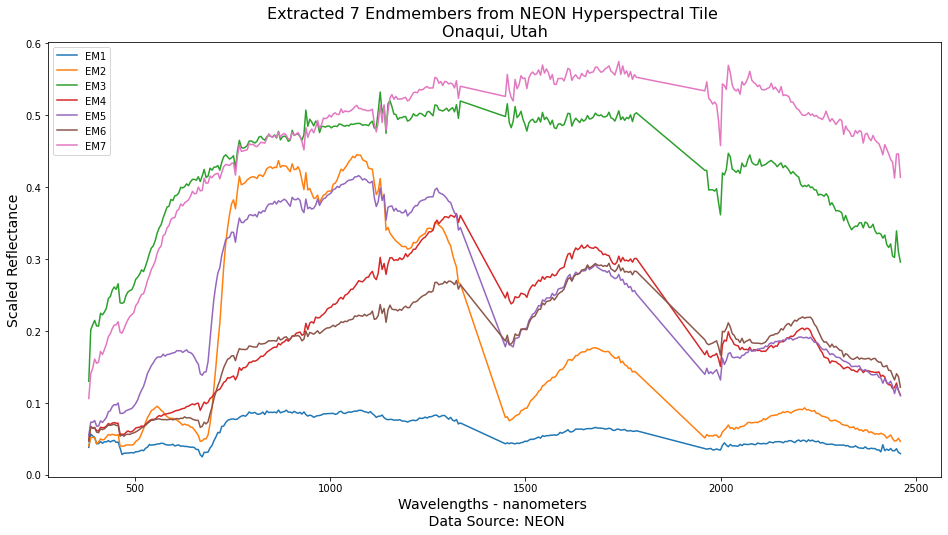

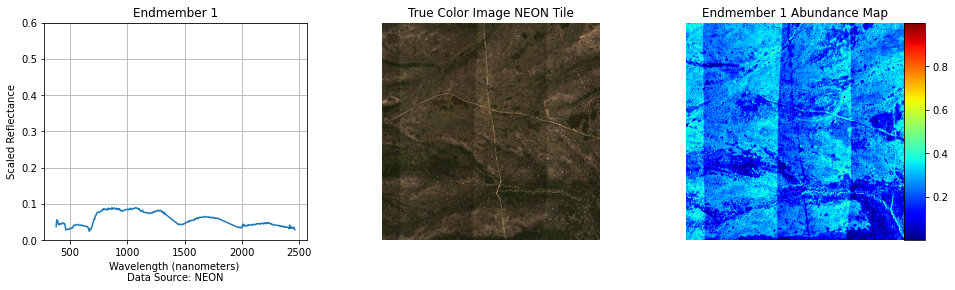

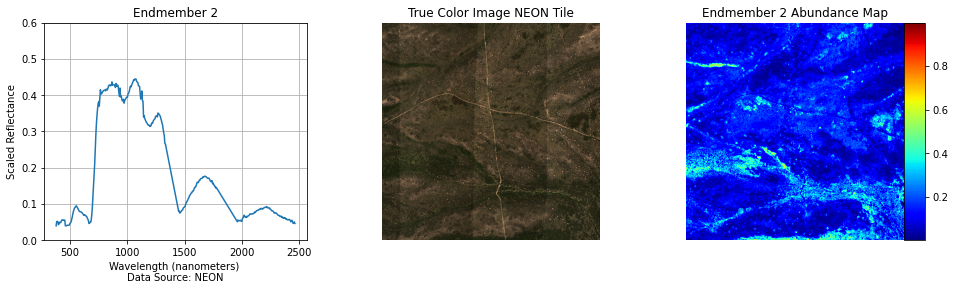

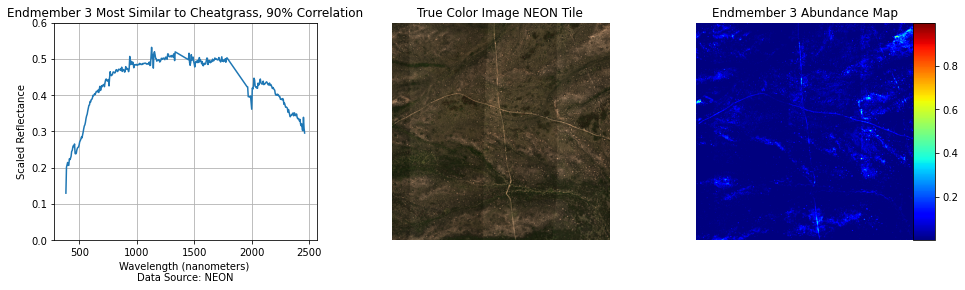

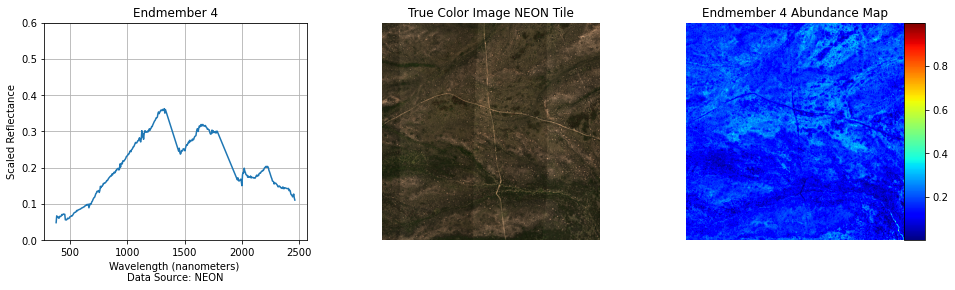

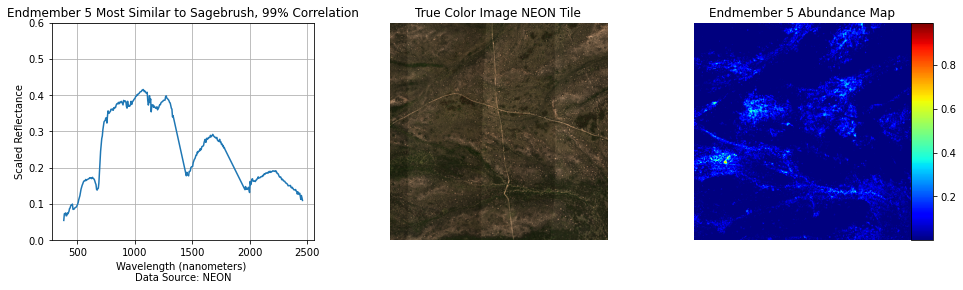

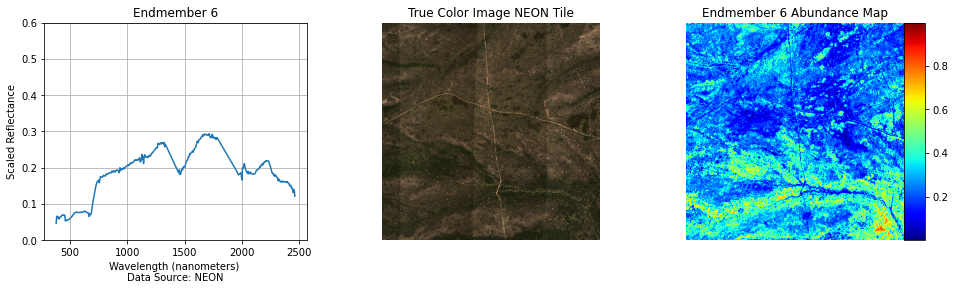

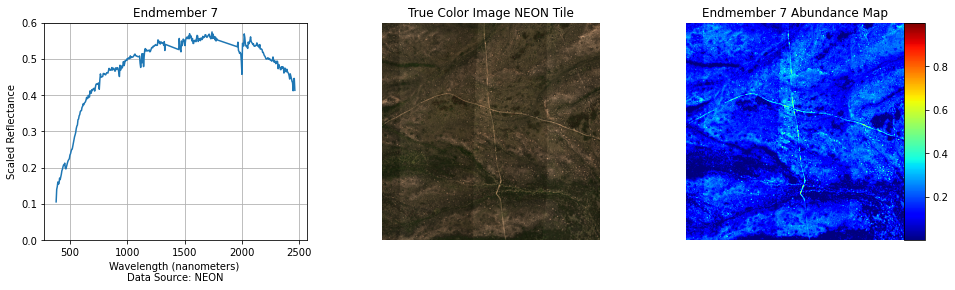

In [11]:
# Calculate PCC for all endmembers and store in a list
coefficient_sagebrush = []
coefficient_cheatgrass = []
for i in range(0, U.shape[0]):
    coefficient_sagebrush.append(pearsonr(
        interp_res_sagebrush, U[i])[0])
    coefficient_cheatgrass.append(pearsonr(
        interp_res_cheatgrass, U[i])[0])
    
# Find the highest PCC for each species
closest_correl_sage = np.array(coefficient_sagebrush).max()
closest_correl_cheat = np.array(coefficient_cheatgrass).max()

# Create plot of all endmembers
plt.figure(figsize=(16, 8))
plt.xlabel('Wavelengths - nanometers \n Data Source: NEON (May 2019)',
           fontsize=14)
plt.ylabel('Scaled Reflectance',
           fontsize=14)
n_em = 0
for endmember in U:
    n_em += 1
    plt.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             endmember,
             label=f'EM{n_em}')
plt.legend()
plt.title(f'Extracted {n_em} Endmembers from NEON Hyperspectral Tile \nOnaqui, Utah',
          fontsize=16)

plt.show()

# Plot triptych of endmember, rgb tile, and endmember abundance
n_em = 0
for i, em in enumerate(U):
    n_em += 1
    fig = plt.figure(figsize=(16, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
    
    #ax0 is endmember line plot
    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'], em)
    ax0.grid(True)
    ax0.set_ylim(0, 0.6)
    ax0.set_xlabel('Wavelength (nanometers) \n'
                   'Data Source: NEON (May 2019)',
                   fontsize=10)
    ax0.set_ylabel('Scaled Reflectance',
                   fontsize=10)
    
    # Label closest match to sage/cheatgrass and print percent correlation
    if (pearsonr(interp_res_sagebrush, em)[0]) == closest_correl_sage:
        plt.title(
            f'Endmember {n_em} {int(closest_correl_sage*100)}% Correlation to Sagebrush')
    elif (pearsonr(interp_res_cheatgrass, em)[0]) == closest_correl_cheat:
        plt.title(
            f'Endmember {n_em} {int(closest_correl_cheat*100)}% Correlation to Cheatgrass')
    else:
        plt.title(f'Endmember {n_em}')
  
    #ax1 is RGB tile
    ax1 = plt.subplot(gs[1])
    ax1.set_axis_off()
    im1 = ax1.imshow(
        bytescale(ONAQ_data['378000_4452000']['reflectance'][:, :, [54, 34, 22]]))
    plt.title('True Color Image NEON Tile')
    
    #ax2 is abundance map
    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(amaps[:, :, i], cmap='jet')
    ax2.set_axis_off()
    plt.title(f'Endmember {n_em} Abundance Map')

    # Configure cmap scale bar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="10%", pad=0.001)

    plt.colorbar(im2, cax=cax)
    plt.show()

## Results of Endmember Extraction Correlated to Sagebrush and Cheatgrass

These plots identify endmembers 3 and 5 as cheatgrass and sagebrush with a 90% and 99% Pearon's Coefficient, respectively. Additional research needs to be conducted to determine what degree of correlation is sufficient to validate endmember identity and whether a Principal Component Analysis should be used instead of Pearson's Correlation Coefficient to statistically compare spectra. Ideally, once a confidence threshold has been identified, this code would include additional validation to identify not just the endmember with the maximum correlation coefficient, but whether that correlation coefficient is in fact over that significance threshold.

## Plot Focal Endmembers with Isolated Spectral Signatures of Focal Species

Since these correlation coefficients are >=90%, I plotted the correlating endmembers with the isolated spectral curves to visualize the similarity.

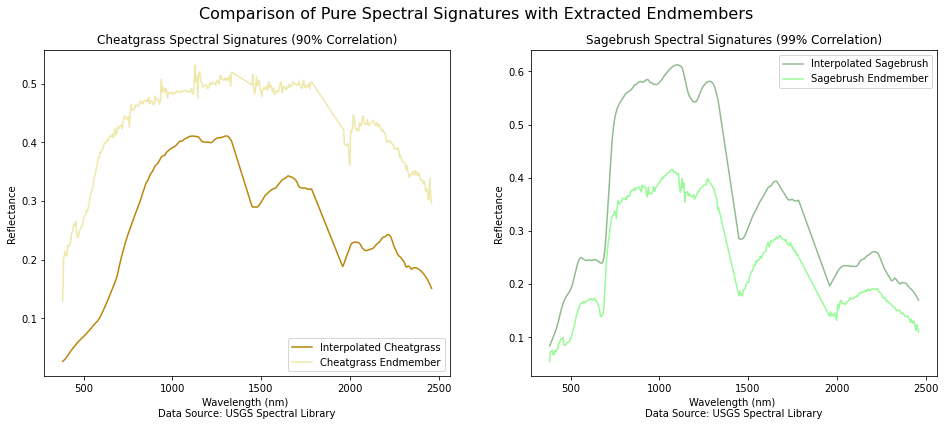

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Comparison of Pure Spectral Signatures with Extracted Endmembers',
             fontsize=16)
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         interp_res_cheatgrass, label='Interpolated Cheatgrass',
         color='darkgoldenrod')
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         U[2], color='palegoldenrod',
         label='Cheatgrass Endmember')
ax0.set_xlabel('Wavelength (nm) \n'
               'Data Source: USGS Spectral Library \n NEON',
               fontsize=10)
ax0.set_ylabel('Reflectance')
ax0.set_title('Cheatgrass Spectral Signatures (90% Correlation)')
ax0.legend()

ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         interp_res_sagebrush, label='Interpolated Sagebrush',
         color='darkseagreen')
ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
         U[4],
         label='Sagebrush Endmember',
         color='palegreen')
ax1.set_xlabel('Wavelength (nm) \n'
               'Data Source: USGS Spectral Library \n NEON',
               fontsize=10)

ax1.set_ylabel('Reflectance')
ax1.set_title('Sagebrush Spectral Signatures (99% Correlation)')
ax1.legend()
plt.show()

## Results of Endmember Comparison with Isolated Spectral Signatures

The comparison of spectral signatures from the isolated plants versus the unsupervised extraction of endmembers reveals a difference in reflectance values but a strong similarity in curve. Whether the differences in reflectance values are due to differences in measurement instrument, sample population, or scaling of reflectance values is a subject for further research. 

# Discussion
## Limitations of Remote Sensing Data in Sagebrush Ecosystems

This workflow and the associated LIDAR and LANDSAT8 workflows have explored a variety of remote sensing data available for the western United States, and therefore applicable to sagebrush ecosystem modeling. While the inability of LIDAR CHMs to capture sagebrush is derives from the modeling algorithm used - see the associated repository <a href= "https://github.com/kessb/sagebrush-ecosystem-modeling/tree/master" target="blank" >here</a> for a full discussion - there is a common denominator preventing data validation for remote sensing products in these ecosystems. 

Obviously, finding pre-collected, open-source *insitu* and remote sensing data in the same area at roughly the same time is a challenge for any project. NEON is one of the best and most comprehensive sources for freely published environmental data in almost every form and facet: All data is thoroughly documented. There is often a variety of resources for learning how to analyze the data through open-source programming; and, because they repeat the same diverse data collection across their many US sites on an annual or biannual basis, there is an excellent coverage of spatially and temporally overlapping data products which can be compared. But, the usefulness of some of these data varies by landscape. 

In our case, every attempt to validate data was been prevented by *insitu* collection methods which do not include smaller vegetation for their validation purposes. This, unfortunately, appears to include sagebrush. It also raises the question of 1) how we can best validate data collected from arid/semi-arid environments where vegetation typically does not grow to sizes visible from remote sensing instruments, and 2) how we define visibility of that vegetation. When considering smaller vegetation, the population size and density may be more useful and applicable than individual size for validation purposes. This workflow does suggests that sagebrush are visible to airborne hyperspectral devices, echoing a 2012 study by Fairweather et al. which identified sagebrush and validated the results against *insitu* data they collected. 

## Next Steps

The results from this project show promise in applying endmember extraction algorithms to identify two species of ecological significance: the foundational sagebrush and invasive cheatgrass. However, additional work is needed to delineate between plant species and improve data validation options. 

I delineated between spectra correlating with sagebrush and cheatgrass here, but since these vegetation types are significantly different ecologically, phenologically, and taxonomically, we cannot rule out the possibility that we are confounding vegetation types within these shrub/grass categories. It is possible that mutliple shrubs are being grouped into the sagebrush endmember spectra, therefore these abundance maps may be overestimating the presences of sagebrush. Likewise, the cheatgrass spectra may include more than one grass-type. To see how vegetation spectra are being grouped, additional work needs to be done comparing the spectra of sympatric grass and shrub species within like-groups at this site. Unfortunately, this is limited by the number of spectra available in spectral libraries for plant species in sagebrush ecosystems. We were unable to find signatures for native bunch grasses or associated shrub species to compare Pearson's Coefficients of spectral signatures within similar vegetation groups.

This brings us back the underlying issues with data validation. Clearly, there are several applicable, open source remote sensing data options available. But, in some respects, these data are putting the cart before the horse since data validation methods are currently biased against arid/semi-arid environments. However, these data may be confirmed through other datasets not publicly available. Consequently, I'm still developing the workflows to 1) subset flightlines to NEON's plots, in case methods to map the sage in these plots arise and 2) extract spectral signatures of isolated pixels which could be validated against *insitu* data with geolocated sagebrush or cheatgrass.

Further analyses are also needed to quantify differences in the abundance maps between LANDSAT8 and NEON hyperspectral data which will require upscaling or downscaling one of the data sources. Once this workflow is complete, spectral and spatial analyses could be expanded to other products (such as AVIRIS or ASTER), or replicated in other sites. While any spectral/spatial resolution would suffer from the same issues with data validation, we can still learn generally how these different products are able to classify sagebrush ecosystems.